In [1]:
from os import path 

import anndata
import openTSNE
import scanpy as sc
import numpy as np
import pandas as pd

import utils

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
adata = anndata.read_h5ad(path.join("..", "data", "h5ad", "cao_2019.h5ad"))
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 2058652 × 26183
    obs: 'id', 'sex', 'day', 'Total_mRNAs', 'tsne_1', 'tsne_2', 'cluster_id', 'sub_tsne_1', 'sub_tsne_2', 'Sub_Cluster', 'db_score', 'detected_doublet', 'potential_doublet_cluster'
    var: 'gene_id', 'gene_type'
    uns: 'name', 'organism', 'tissue', 'year'

In [3]:
adata.obs.head()

,id,sex,day,Total_mRNAs,tsne_1,tsne_2,cluster_id,sub_tsne_1,sub_tsne_2,Sub_Cluster,db_score,detected_doublet,potential_doublet_cluster
sample,,,,,,,,,,,,,
sci3-me-001.GTCGGAGTTTGAGGTAGAA,38,F,13.5,335.0,2.502835,2.589219,5.0,0.00000,0.000000,unknown,0.013367,False,nan
sci3-me-001.ATTAGTCTGTGTATAATACG,9,M,11.5,1989.0,19.352971,-5.523709,20.0,4.01933,18.306513,1,0.004160,False,False
sci3-me-001.GAGGAACTTAATACCATCC,26,F,10.5,393.0,-15.372493,-5.759600,21.0,0.00000,0.000000,unknown,0.002524,False,nan
sci3-me-001.TTCGCGGATACTCTCTCAA,16,F,13.5,227.0,-0.750546,1.439024,17.0,0.00000,0.000000,unknown,0.006938,False,nan
sci3-me-001.ACTGGTTATTTGCGCCATCT,33,M,12.5,241.0,2.402283,12.564681,6.0,0.00000,0.000000,unknown,0.002918,False,nan


## Remove doublets

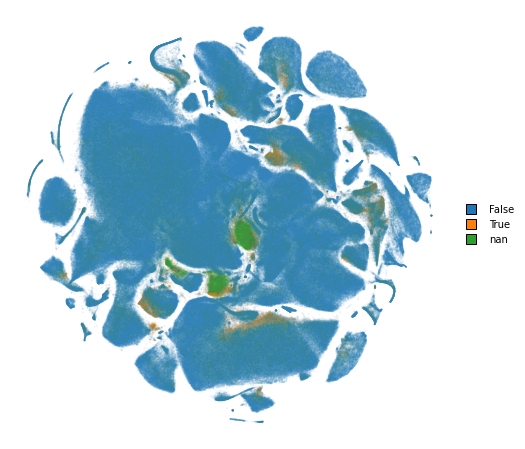

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
utils.plot(adata.obs[["tsne_1", "tsne_2"]].values, adata.obs["detected_doublet"].values,
           s=1, alpha=0.04, draw_legend=True, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")
ax.set_aspect("equal", adjustable="box")

In [5]:
print("Removing %d putative doublets" % np.sum(adata.obs["detected_doublet"] == "nan"))
adata = adata[adata.obs["detected_doublet"] != "nan"]
adata

Removing 32011 putative doublets


View of AnnData object with n_obs × n_vars = 2026641 × 26183
    obs: 'id', 'sex', 'day', 'Total_mRNAs', 'tsne_1', 'tsne_2', 'cluster_id', 'sub_tsne_1', 'sub_tsne_2', 'Sub_Cluster', 'db_score', 'detected_doublet', 'potential_doublet_cluster'
    var: 'gene_id', 'gene_type'
    uns: 'name', 'organism', 'tissue', 'year'

## Preprocessing

In [6]:
sc.pp.filter_genes(adata, min_counts=10)
adata

Trying to set attribute `.var` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 2026641 × 26180
    obs: 'id', 'sex', 'day', 'Total_mRNAs', 'tsne_1', 'tsne_2', 'cluster_id', 'sub_tsne_1', 'sub_tsne_2', 'Sub_Cluster', 'db_score', 'detected_doublet', 'potential_doublet_cluster'
    var: 'gene_id', 'gene_type', 'n_counts'
    uns: 'name', 'organism', 'tissue', 'year'

Chosen offset: 0.07
CPU times: user 1min 22s, sys: 1min 12s, total: 2min 34s
Wall time: 2min 32s


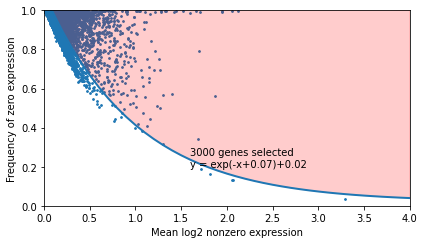

In [7]:
%time gene_mask = utils.select_genes(adata.X, n=3000, threshold=0)

In [8]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
adata.obsm["X_pca"] = utils.pca(adata.X[:, gene_mask])

## Sample embedding

In [10]:
np.random.seed(0)

In [11]:
x, y = adata.obsm["X_pca"], adata.obs["day"]

In [12]:
indices = np.random.permutation(list(range(x.shape[0])))
reverse = np.argsort(indices)

x_sample, x_rest = x[indices[:25000]], x[indices[25000:]]
y_sample, y_rest = y[indices[:25000]], y[indices[25000:]]

### Create sample embedding

In [13]:
%%time
sample_affinities = openTSNE.affinity.PerplexityBasedNN(
    x_sample,
    perplexity=500,
    metric="cosine",
    n_jobs=24,
    random_state=0,
    verbose=True,
)

===> Finding 1500 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 15.08 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 9.01 seconds
CPU times: user 4min 34s, sys: 6.88 s, total: 4min 41s
Wall time: 24.1 s


In [14]:
%time sample_init = openTSNE.initialization.spectral(sample_affinities.P)

CPU times: user 2min 26s, sys: 2min 45s, total: 5min 12s
Wall time: 12.8 s


In [15]:
sample_embedding = openTSNE.TSNEEmbedding(sample_init, sample_affinities, n_jobs=24, verbose=True)

In [16]:
%time sample_embedding1 = sample_embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5)

===> Running optimization with exaggeration=12.00, lr=2083.33 for 250 iterations...
Iteration   50, KL divergence 3.1733, 50 iterations in 4.5145 sec
Iteration  100, KL divergence 3.0712, 50 iterations in 4.8169 sec
Iteration  150, KL divergence 3.0691, 50 iterations in 4.6730 sec
Iteration  200, KL divergence 3.0689, 50 iterations in 4.6598 sec
Iteration  250, KL divergence 3.0688, 50 iterations in 4.6715 sec
   --> Time elapsed: 23.34 seconds
CPU times: user 6min 58s, sys: 5.62 s, total: 7min 4s
Wall time: 23.7 s


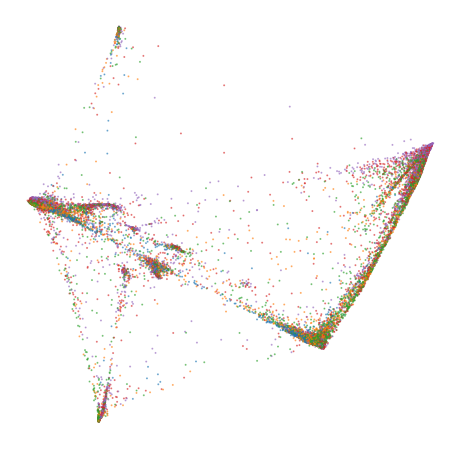

In [17]:
utils.plot(sample_embedding1, y[indices[:25000]], alpha=0.5, draw_legend=False)

In [18]:
%time sample_embedding2 = sample_embedding1.optimize(n_iter=500, exaggeration=1, momentum=0.8)

===> Running optimization with exaggeration=1.00, lr=2083.33 for 500 iterations...
Iteration   50, KL divergence 1.5463, 50 iterations in 4.7214 sec
Iteration  100, KL divergence 1.3437, 50 iterations in 4.5940 sec
Iteration  150, KL divergence 1.2702, 50 iterations in 4.5971 sec
Iteration  200, KL divergence 1.2353, 50 iterations in 4.7621 sec
Iteration  250, KL divergence 1.2168, 50 iterations in 5.0521 sec
Iteration  300, KL divergence 1.2057, 50 iterations in 5.4702 sec
Iteration  350, KL divergence 1.1999, 50 iterations in 5.6115 sec
Iteration  400, KL divergence 1.1957, 50 iterations in 5.7389 sec
Iteration  450, KL divergence 1.1923, 50 iterations in 5.8070 sec
Iteration  500, KL divergence 1.1901, 50 iterations in 6.1898 sec
   --> Time elapsed: 52.55 seconds
CPU times: user 15min 7s, sys: 7.2 s, total: 15min 14s
Wall time: 52.8 s


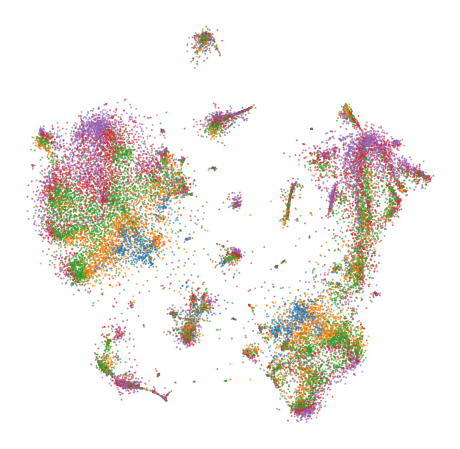

In [19]:
utils.plot(sample_embedding2, y[indices[:25000]], alpha=0.5, draw_legend=False)

## Full embedding

In [20]:
%%time
affinities = openTSNE.affinity.PerplexityBasedNN(
    x,
    perplexity=30,
    metric="cosine",
    n_jobs=24,
    random_state=0,
    verbose=True,
)

===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 350.42 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 73.43 seconds
CPU times: user 56min 31s, sys: 1min 51s, total: 58min 23s
Wall time: 7min 3s


In [21]:
%time rest_init = sample_embedding2.prepare_partial(x_rest, k=1, perplexity=1/3)

===> Finding 1 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 399.05 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.59 seconds
CPU times: user 10min 11s, sys: 1min 34s, total: 11min 45s
Wall time: 6min 40s


In [22]:
init_full = np.vstack((sample_embedding2, rest_init))[reverse]

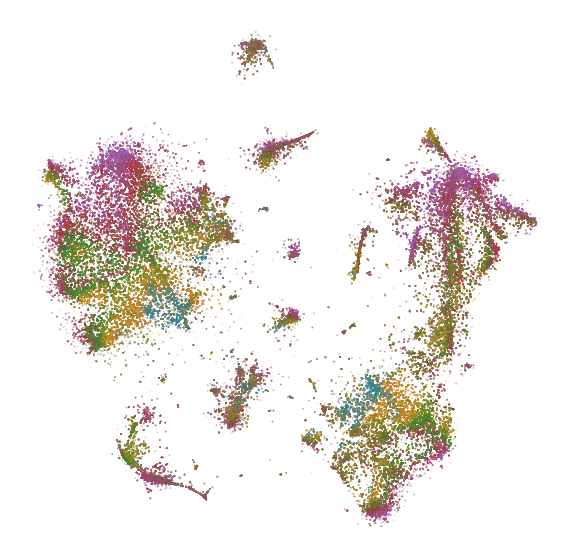

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
utils.plot(init_full, y, ax=ax, draw_legend=False, s=1, alpha=0.05)

In [24]:
init_full = init_full / (np.std(init_full[:, 0]) * 10000)
np.std(init_full, axis=0)

array([1.0000000e-04, 7.2645813e-05])

In [25]:
embedding = openTSNE.TSNEEmbedding(init_full, affinities, n_jobs=8, random_state=42, verbose=True)

In [26]:
%time embedding1 = embedding.optimize(n_iter=500, exaggeration=12, momentum=0.5)

===> Running optimization with exaggeration=12.00, lr=168886.75 for 500 iterations...
Iteration   50, KL divergence 9.6875, 50 iterations in 144.8389 sec
Iteration  100, KL divergence 9.0291, 50 iterations in 148.5091 sec
Iteration  150, KL divergence 8.8574, 50 iterations in 152.4323 sec
Iteration  200, KL divergence 8.7675, 50 iterations in 155.7523 sec
Iteration  250, KL divergence 8.7093, 50 iterations in 151.0929 sec
Iteration  300, KL divergence 8.6707, 50 iterations in 157.8515 sec
Iteration  350, KL divergence 8.6436, 50 iterations in 155.6736 sec
Iteration  400, KL divergence 8.6219, 50 iterations in 157.6268 sec
Iteration  450, KL divergence 8.6021, 50 iterations in 155.8594 sec
Iteration  500, KL divergence 8.5879, 50 iterations in 158.7211 sec
   --> Time elapsed: 1538.36 seconds
CPU times: user 2h 7min 48s, sys: 6min 34s, total: 2h 14min 23s
Wall time: 25min 46s


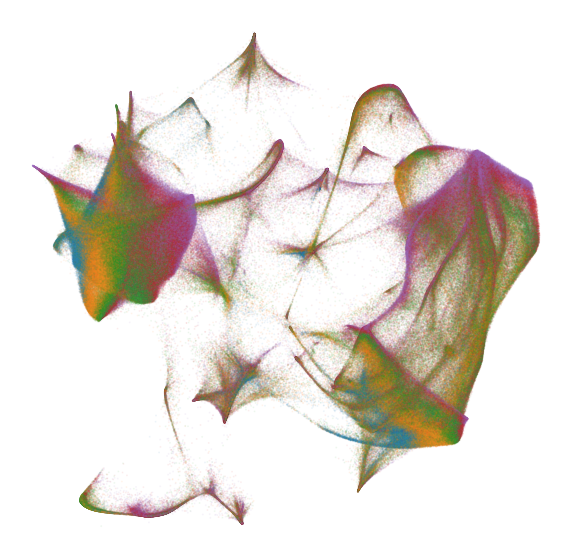

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
utils.plot(embedding1, y, ax=ax, draw_legend=False, s=1, alpha=0.05)

In [28]:
%time embedding2 = embedding1.optimize(n_iter=500, exaggeration=4, momentum=0.8)

===> Running optimization with exaggeration=4.00, lr=168886.75 for 500 iterations...
Iteration   50, KL divergence 7.7460, 50 iterations in 155.5098 sec
Iteration  100, KL divergence 7.4936, 50 iterations in 156.3738 sec
Iteration  150, KL divergence 7.3793, 50 iterations in 155.0865 sec
Iteration  200, KL divergence 7.3076, 50 iterations in 155.9813 sec
Iteration  250, KL divergence 7.2641, 50 iterations in 151.0417 sec
Iteration  300, KL divergence 7.2311, 50 iterations in 148.8018 sec
Iteration  350, KL divergence 7.2073, 50 iterations in 157.4513 sec
Iteration  400, KL divergence 7.1894, 50 iterations in 154.5067 sec
Iteration  450, KL divergence 7.1753, 50 iterations in 151.8887 sec
Iteration  500, KL divergence 7.1635, 50 iterations in 148.8921 sec
   --> Time elapsed: 1535.54 seconds
CPU times: user 2h 10min 18s, sys: 6min 51s, total: 2h 17min 10s
Wall time: 25min 44s


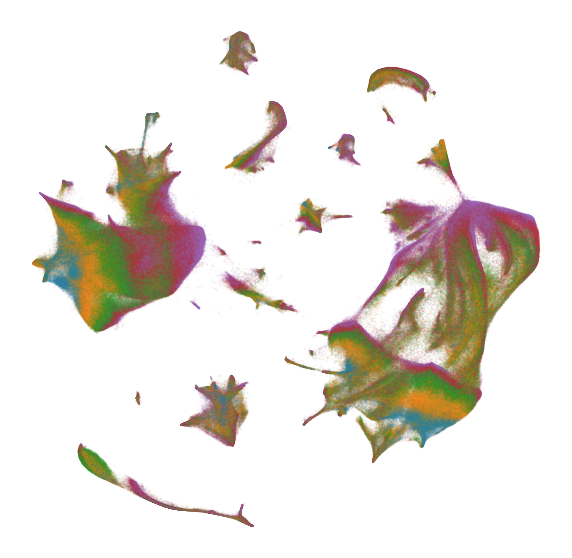

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
utils.plot(embedding2, y, ax=ax, draw_legend=False, s=1, alpha=0.05)

In [30]:
%time embedding3 = embedding2.optimize(n_iter=500, exaggeration=2, momentum=0.8)

===> Running optimization with exaggeration=2.00, lr=168886.75 for 500 iterations...
Iteration   50, KL divergence 6.7342, 50 iterations in 151.0170 sec
Iteration  100, KL divergence 6.5834, 50 iterations in 157.6041 sec
Iteration  150, KL divergence 6.4756, 50 iterations in 154.4179 sec
Iteration  200, KL divergence 6.3981, 50 iterations in 160.4640 sec
Iteration  250, KL divergence 6.3396, 50 iterations in 162.2740 sec
Iteration  300, KL divergence 6.2935, 50 iterations in 159.4266 sec
Iteration  350, KL divergence 6.2563, 50 iterations in 160.9133 sec
Iteration  400, KL divergence 6.2257, 50 iterations in 166.0588 sec
Iteration  450, KL divergence 6.1997, 50 iterations in 156.5140 sec
Iteration  500, KL divergence 6.1776, 50 iterations in 154.9050 sec
   --> Time elapsed: 1583.60 seconds
CPU times: user 2h 14min 29s, sys: 7min 14s, total: 2h 21min 43s
Wall time: 26min 32s


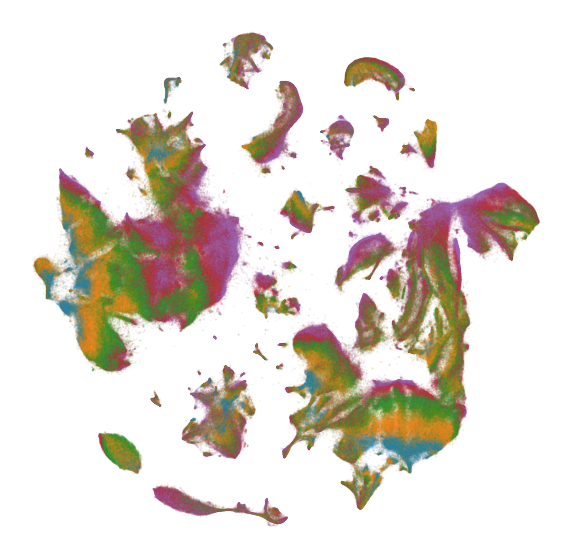

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
utils.plot(embedding3, y, ax=ax, draw_legend=False, s=1, alpha=0.05)

In [32]:
%time embedding4 = embedding3.optimize(n_iter=500, exaggeration=1, momentum=0.8)

===> Running optimization with exaggeration=1.00, lr=168886.75 for 500 iterations...
Iteration   50, KL divergence 6.0025, 50 iterations in 157.3155 sec
Iteration  100, KL divergence 5.9215, 50 iterations in 159.8330 sec
Iteration  150, KL divergence 5.8431, 50 iterations in 159.9271 sec
Iteration  200, KL divergence 5.7680, 50 iterations in 160.8286 sec
Iteration  250, KL divergence 5.7004, 50 iterations in 164.8584 sec
Iteration  300, KL divergence 5.6413, 50 iterations in 166.0571 sec
Iteration  350, KL divergence 5.5900, 50 iterations in 169.7945 sec
Iteration  400, KL divergence 5.5454, 50 iterations in 169.3629 sec
Iteration  450, KL divergence 5.5066, 50 iterations in 177.4681 sec
Iteration  500, KL divergence 5.4743, 50 iterations in 196.5896 sec
   --> Time elapsed: 1682.04 seconds
CPU times: user 2h 11min 29s, sys: 7min 34s, total: 2h 19min 3s
Wall time: 28min 8s


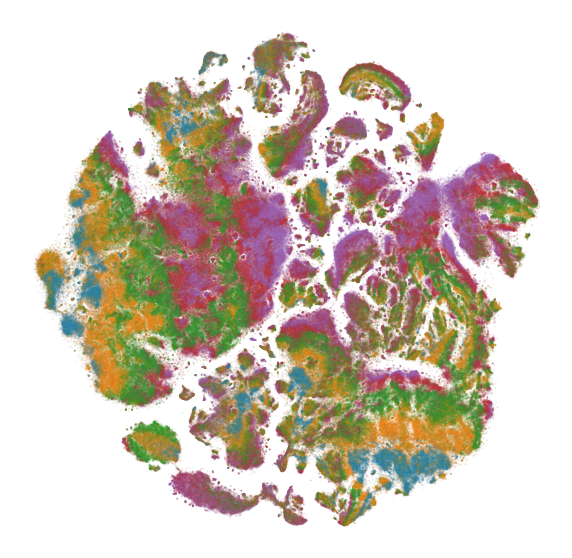

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
utils.plot(embedding4, y, ax=ax, draw_legend=False, s=1, alpha=0.05)

In [34]:
pd.DataFrame(embedding2, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("cao/exag4.csv")
pd.DataFrame(embedding3, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("cao/exag2.csv")
pd.DataFrame(embedding4, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("cao/exag1.csv")

In [35]:
import pandas as pd

embedding2 = pd.read_csv("cao/exag4.csv.gz", index_col=0).values
embedding3 = pd.read_csv("cao/exag2.csv.gz", index_col=0).values
embedding4 = pd.read_csv("cao/exag1.csv.gz", index_col=0).values

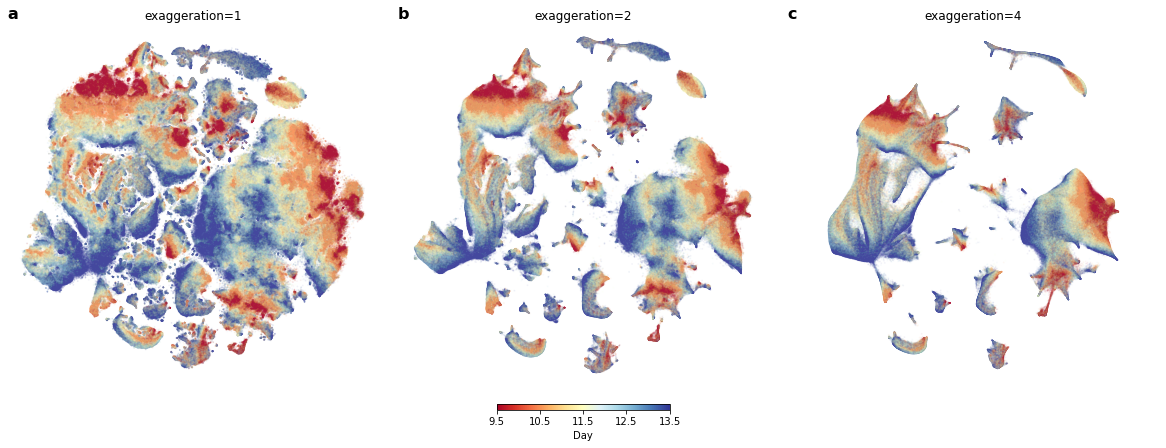

In [36]:
import string

fig, ax = plt.subplots(ncols=3, figsize=(16, 16/3))

#rand_idx = np.random.choice(range(adata.shape[0]), size=(5000), replace=False)
    
for emb, exag, ax_ in zip([embedding4, embedding3, embedding2], [1, 2, 4], ax.ravel()):
    sc = ax_.scatter(emb[:, 0], emb[:, 1], c=adata.obs["day"], cmap="RdYlBu", alpha=0.04, s=1, rasterized=True)
    #sc = ax_.scatter(emb[rand_idx, 0], emb[rand_idx, 1], c=adata.obs["day"][rand_idx],
    #                 cmap="RdYlBu", alpha=1, s=3, rasterized=True)
    ax_.set_xticks([]), ax_.set_yticks([])
    ax_.axis("off")
    ax_.axis("equal")
    ax_.set_title(f"exaggeration={exag}", va="baseline")
    
plt.subplots_adjust(wspace=0.05, hspace=0.05, top=1, bottom=0, left=0, right=1)

for ax_, letter in zip(ax.ravel(), string.ascii_lowercase): 
    plt.text(0, 1.02, letter, transform=ax_.transAxes, fontsize=16, va="baseline", fontweight="bold")
    
color_bar = fig.colorbar(sc, ax=ax.ravel().tolist(), ticks=adata.obs["day"].unique(), label="Day",
                         orientation="horizontal", anchor=(0.5, 0), fraction=0.015, aspect=30, pad=0.05)
color_bar.set_alpha(1)
color_bar.draw_all()

#plt.savefig(path.join("..", "figures", "cao2019.pdf"), dpi=300, bbox_inches="tight", transparent=True, width=16, height=16/3)
plt.savefig(path.join("..", "figures", "cao2019.pdf"), dpi=72, bbox_inches="tight", transparent=True, width=1200/72, height=16/3)
#plt.savefig(path.join("..", "figures", "cao2019.tiff"), dpi=150, bbox_inches="tight", transparent=True, width=16, height=16/3)